In [75]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("data/train_ship_segmentations_v2.csv")
train_images_folder = "data/train_v2/"

train_df.shape

(231723, 2)

## Utils

In [76]:
def get_img(img_folder, img_filename):
    img_path = os.path.join(img_folder, img_filename)
    img = cv2.imread(img_path)
    assert img is not None, f"Image {img_filename} doesn't found"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_img_mask(img_filename):
    img_masks = train_df_grouped[train_df_grouped['ImageId'] == img_filename]['EncodedPixels'].values[0].split(',')
    mask = np.zeros((768, 768))
    for m in img_masks:
        mask += rle_decode(m)
    return mask

def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decode a Run-Length Encoded (RLE) binary mask into a 2D numpy array.

    Parameters:
    - mask_rle (str): The RLE-encoded string representing the binary mask.
    - shape (tuple, optional): The shape of the target 2D array. Default is (768, 768).

    Returns:
    - numpy.ndarray: A 2D binary array representing the decoded mask.
    """

    if mask_rle == ['nan']:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T # Needed to align to RLE direction

## EDA

This analysis investigates three main questions: class balance in the dataset, characteristics of image and mask appearances, and the impact of image size on quality.

## Analysis Plan:
1. Ratio of images without ships to images with ships
2. Distribution of images by number of ships
3. Visualization of images without ships, with ships, and their corresponding masks
4. Distribution of images by size
5. Class imbalance within images
6. Visualization of small-sized images

### General structure of the segmentation table

In [77]:
train_df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [78]:
total_entries = train_df.shape[0]
total_images = train_df['ImageId'].unique().size
print(f"Number of entries: {total_entries}\n\
Number of images: {total_images}")

Number of entries: 231723
Number of images: 192556


The number of records exceeds the number of images, indicating that each object has its own mask, and each mask is a separate record.

## Ratio of Images With and Without Ships

Our task is to detect ships in images, so we're interested in two classes: images with ships and images without ships. 

It's crucial to establish the class imbalance upfront, as this is one of the key challenges in semantic segmentation.

In [79]:
# When grouping by id, we immediately aggregate masks by connecting them with a comma (',')
train_df['HasShip'] = train_df['EncodedPixels'].notna().apply(lambda x: 1 if x == True else 0)
train_df_grouped = train_df.groupby('ImageId').agg({'EncodedPixels': lambda x: ','.join(x.astype('str')), 
                                                 'HasShip': 'sum'}).reset_index()

train_df_grouped.rename(columns={'HasShip': 'ShipsAmount'}, inplace=True)
train_df_grouped.head()

ImageId                                      EncodedPixels  \
0  00003e153.jpg                                                nan   
1  0001124c7.jpg                                                nan   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4  0001b1832.jpg                                                nan   

   ShipsAmount  
0            0  
1            0  
2            1  
3            5  
4            0

In [80]:
images_without_ships = train_df_grouped.query('ShipsAmount == 0')
images_with_ships = train_df_grouped.query('ShipsAmount > 0')
print(f"Number of images without ships: {images_without_ships.shape[0]} | {int(round(images_without_ships.shape[0]/total_images, 2) * 100)}%\n\
Number of images with ships: {images_with_ships.shape[0]} | {int(round(images_with_ships.shape[0]/total_images, 2) * 100)}%\n")
images_with_ships.describe()

Number of images without ships: 150000 | 78%
Number of images with ships: 42556 | 22%



ShipsAmount
count  42556.000000
mean       1.920364
std        1.906073
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       15.000000

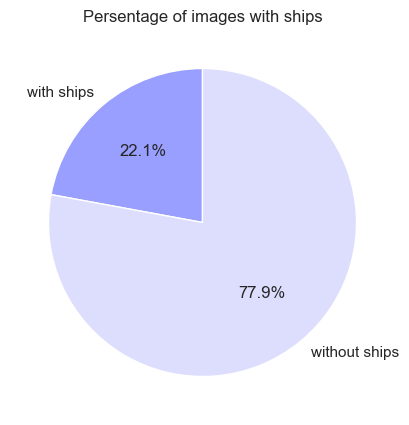

In [81]:
plt.figure(figsize=(10, 5))
plt.pie([images_with_ships.shape[0], images_without_ships.shape[0]], labels=['with ships', 'without ships'], 
        autopct='%1.1f%%', startangle=90,  wedgeprops={"linewidth": 1, "edgecolor": "white"}, colors = ['#999fff','#ddddfd'])
plt.title('Persentage of images with ships')
plt.show()

We can observe a significant imbalance with a prevalence of images without ships, at a ratio of nearly 1 to 5. 

This may create problems during training, as the model might learn to ignore ships due to a skewed evaluation metric that would be high by predicting background instead of ships.

## Analysis of Image Distribution by Number of Ships

Depending on the distribution of ship counts, we might want to reduce the number of certain cases during data splitting to allow the model to generalize well on ship features rather than their clusters.

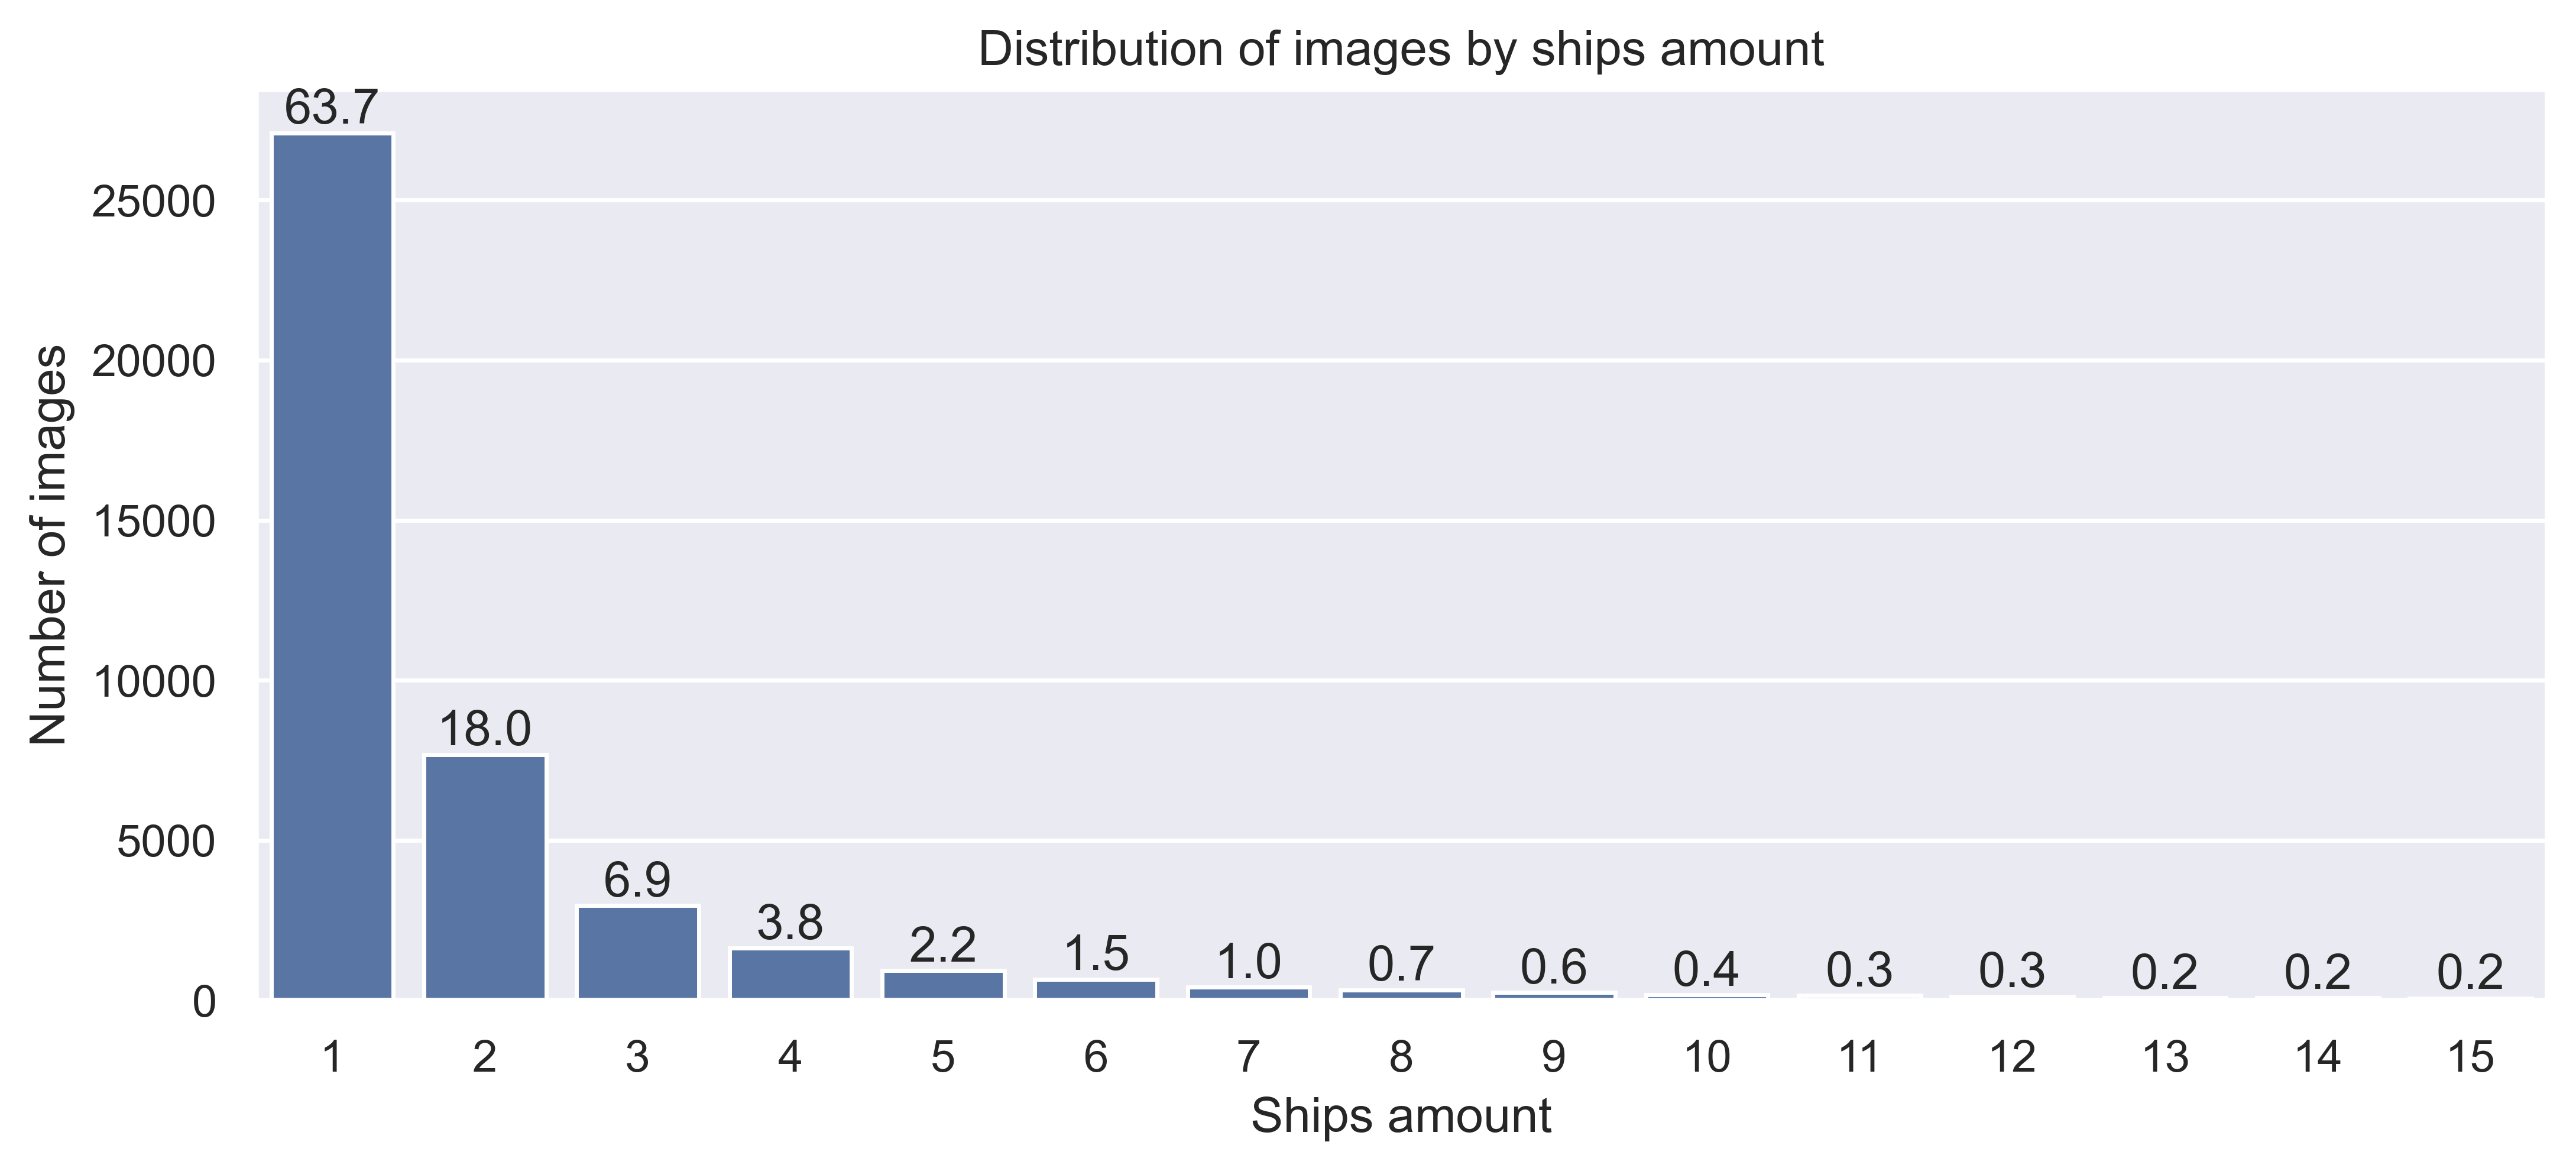

In [23]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10, 4), dpi=500)
ships_dist_count = sns.barplot(ax=ax, data=images_with_ships['ShipsAmount'].value_counts().reset_index(), x='ShipsAmount', y='count')

# Add percentage labels to the bars
ax.bar_label(ax.containers[0], labels=np.around(images_with_ships['ShipsAmount'].value_counts(normalize=True) * 100, decimals=1))

ax.set_title("Distribution of images by ships amount")
ax.set_ylabel("Number of images")
ax.set_xlabel("Ships amount")
plt.show()

The distribution has a long right tail. The vast majority of images with ships contain only one object. Although ~36% of images have more than one ship, with a maximum of 15 objects. 

This could lead to the model poorly learning to recognize complex cases where there are multiple objects in an image.

## Appearance of Images Without Ships, With Ships, and Their Corresponding Masks

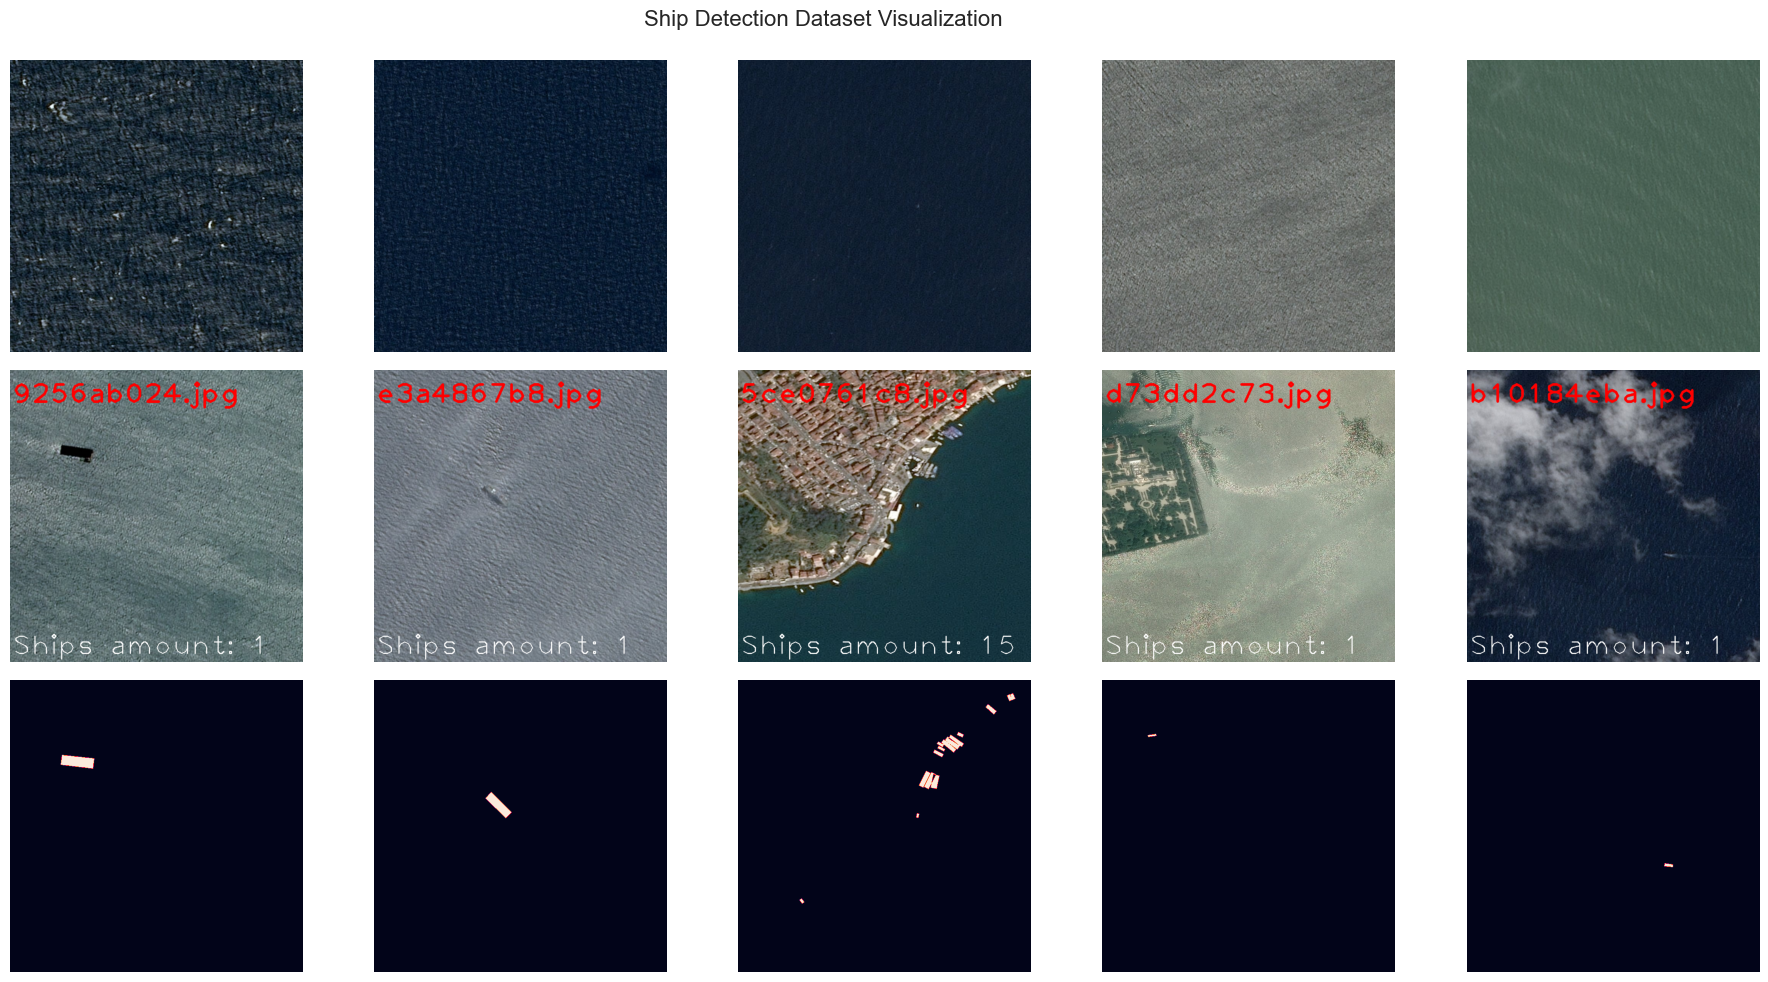

In [24]:
def display_images(data, img_folder, seed=1):
    """
    Display a set of images from the dataset, showing both images with and without ships,
    along with their corresponding masks and annotations.

    Parameters:
    data (DataFrame): A pandas DataFrame containing image metadata including 'ImageId' and 'ShipsAmount'.
    img_folder (str): The directory path where the images are stored.
    seed (int): The random seed for reproducibility. Default is 1.
    """
    num_images = 5
    images_without_ships = data.query('ShipsAmount == 0')
    images_with_ships = data.query('ShipsAmount > 0')

    without_ships_sample = images_without_ships.sample(n=num_images, random_state=seed)['ImageId'].to_list()
    with_ships_sample = images_with_ships.sample(n=num_images, random_state=seed)['ImageId'].to_list()
    
    num_cols = 5
    num_rows = 3
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

    fig.suptitle('Ship Detection Dataset Visualization', fontsize=16)

    for i in range(num_images):
        img_without_ships = get_img(img_folder, without_ships_sample[i])
        img_with_ships = get_img(img_folder, with_ships_sample[i])
        
        mask = get_img_mask(with_ships_sample[i])
        
        ships_num = data[data['ImageId'] == with_ships_sample[i]].values[0][2]
        img_label = f'Ships amount: {ships_num}' if ships_num > 0 else 'No ships'

        # Add a caption to the image with the number of ships
        img_with_ships = cv2.putText(img_with_ships, img_label, (5, 750), cv2.FONT_HERSHEY_PLAIN, 5, (255, 255, 255), thickness=2) 
        # Add a caption with the image ID to the image
        img_with_ships = cv2.putText(img_with_ships, with_ships_sample[i], (5, 90), cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), thickness=5) 
                  
        axes[0, i].imshow(img_without_ships)
        axes[0, i].axis('off')
        axes[1, i].imshow(img_with_ships)
        axes[1, i].axis('off')
        axes[2, i].imshow(mask)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, left=0.07)  
    plt.show()
    
# Feel fry to change the "seed" to see different images
seed = 5
display_images(train_df_grouped, train_images_folder, seed)

Based on the image review, several conclusions can be drawn:

1. Ship sizes vary significantly from image to image
2. Some images contain land elements in addition to water
3. Image contrast varies greatly, particularly the color of the water surface and the color of vessels

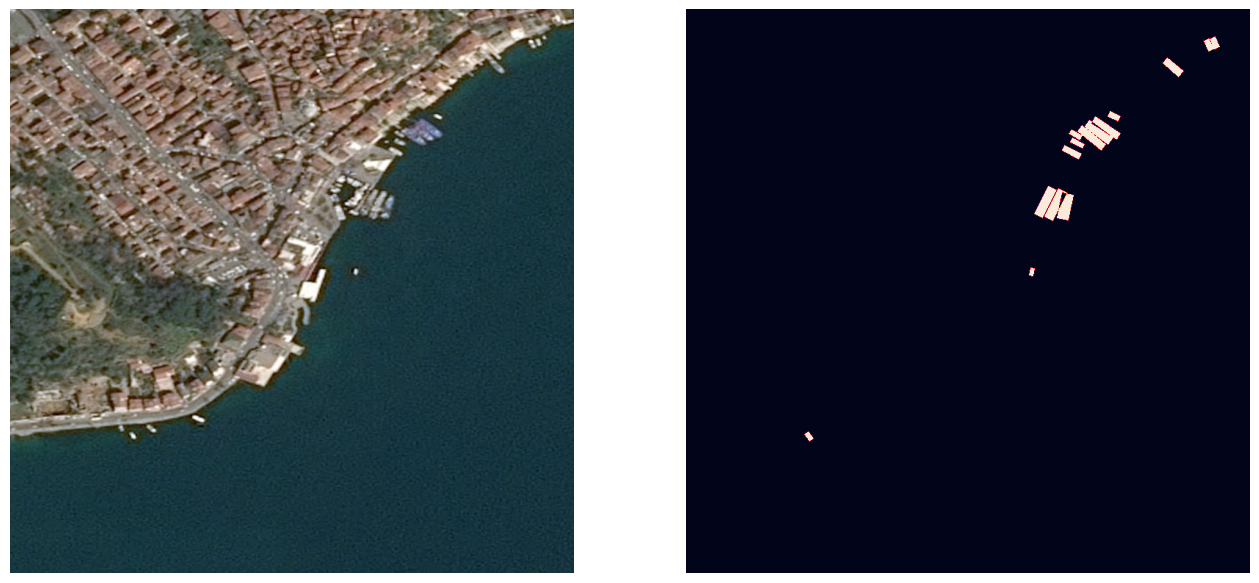

In [25]:
def display_img(img_folder, img_filename):
    """
    Displays a big image from the dataset, showing both its masked and unmasked versions. 
    This can be useful for thoroughly visualizing specific images.

    Parameters:
    img_folder (str): The directory path where the images are stored.
    img_filename (str): the filename of the image file to examine. Example: "5ce0761c8.jpg"
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    img = get_img(img_folder, img_filename)
    mask = get_img_mask(img_filename)
    ax[0].imshow(img)
    ax[1].imshow(mask)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

display_img(train_images_folder, '5ce0761c8.jpg')

It appears that some images may be incorrectly labeled. In the top image, it's clear that at least 8 ships are missing from the mask, which are easy to identify visually. 

Thus, we can expect an underestimated model performance even with factually correct vessel identification.

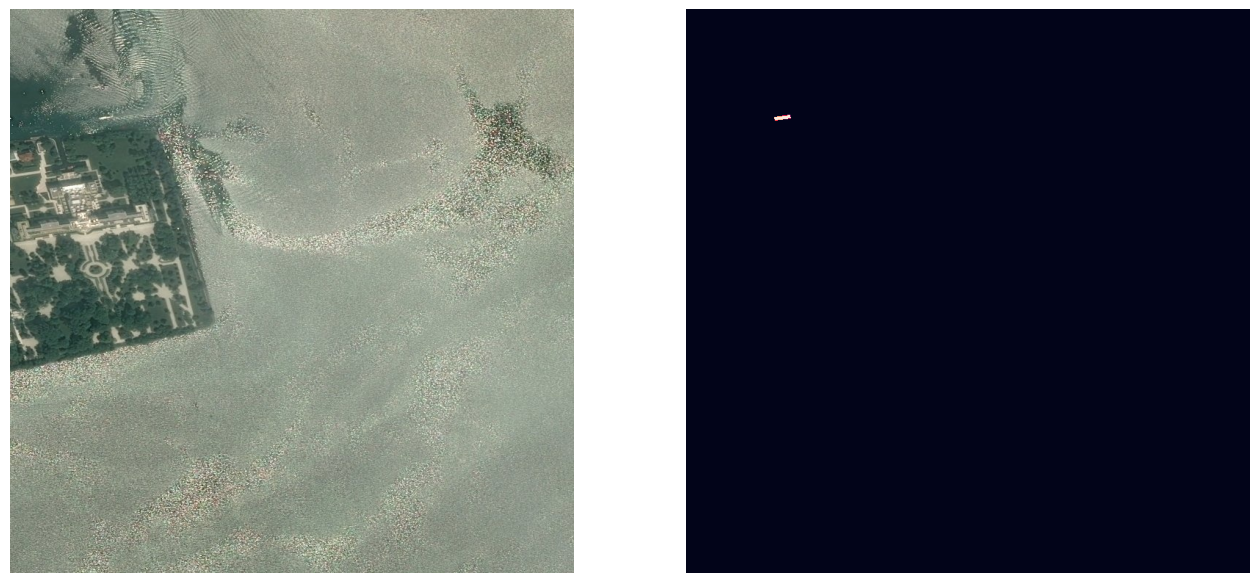

In [26]:
display_img(train_images_folder, 'd73dd2c73.jpg')

In some images, like the one above, it's practically impossible for a human to visually identify the ship. This is likely also a labeling error.

## Class Imbalance Within Images

In [93]:
mask = rle_decode(train_df_grouped[train_df_grouped['ImageId'] == 'd73dd2c73.jpg']['EncodedPixels'].values[0])
mask.shape

(768, 768)

In [96]:
proportion = round(np.count_nonzero(mask) / mask.size , 5)
print(f"Image pixels disbalance: {proportion}")

Image pixels disbalance: 0.00019


Only 0.02% of the total pixel count belongs to the positive class (ship) relative to the overall pixel count. 

The situation will be only slightly better for images with a large number of ships. Therefore, we also face a strong class imbalance within the images.

## Small Images

Small images are often damaged or contain little information. This can negatively impact model training. 

It's necessary to check if this hypothesis holds true for this dataset.

In [11]:
train_df_grouped['FileSizeKb'] = train_df_grouped['ImageId'].map(
            lambda img_filename: os.stat(os.path.join(train_images_folder, img_filename)).st_size/1024
        )

In [16]:
train_df_grouped.head()

ImageId                                      EncodedPixels  \
0  00003e153.jpg                                                nan   
1  0001124c7.jpg                                                nan   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4  0001b1832.jpg                                                nan   

   ShipsAmount  FileSizeKb  
0            0  128.944336  
1            0   76.059570  
2            1  147.625977  
3            5   75.221680  
4            0   95.627930

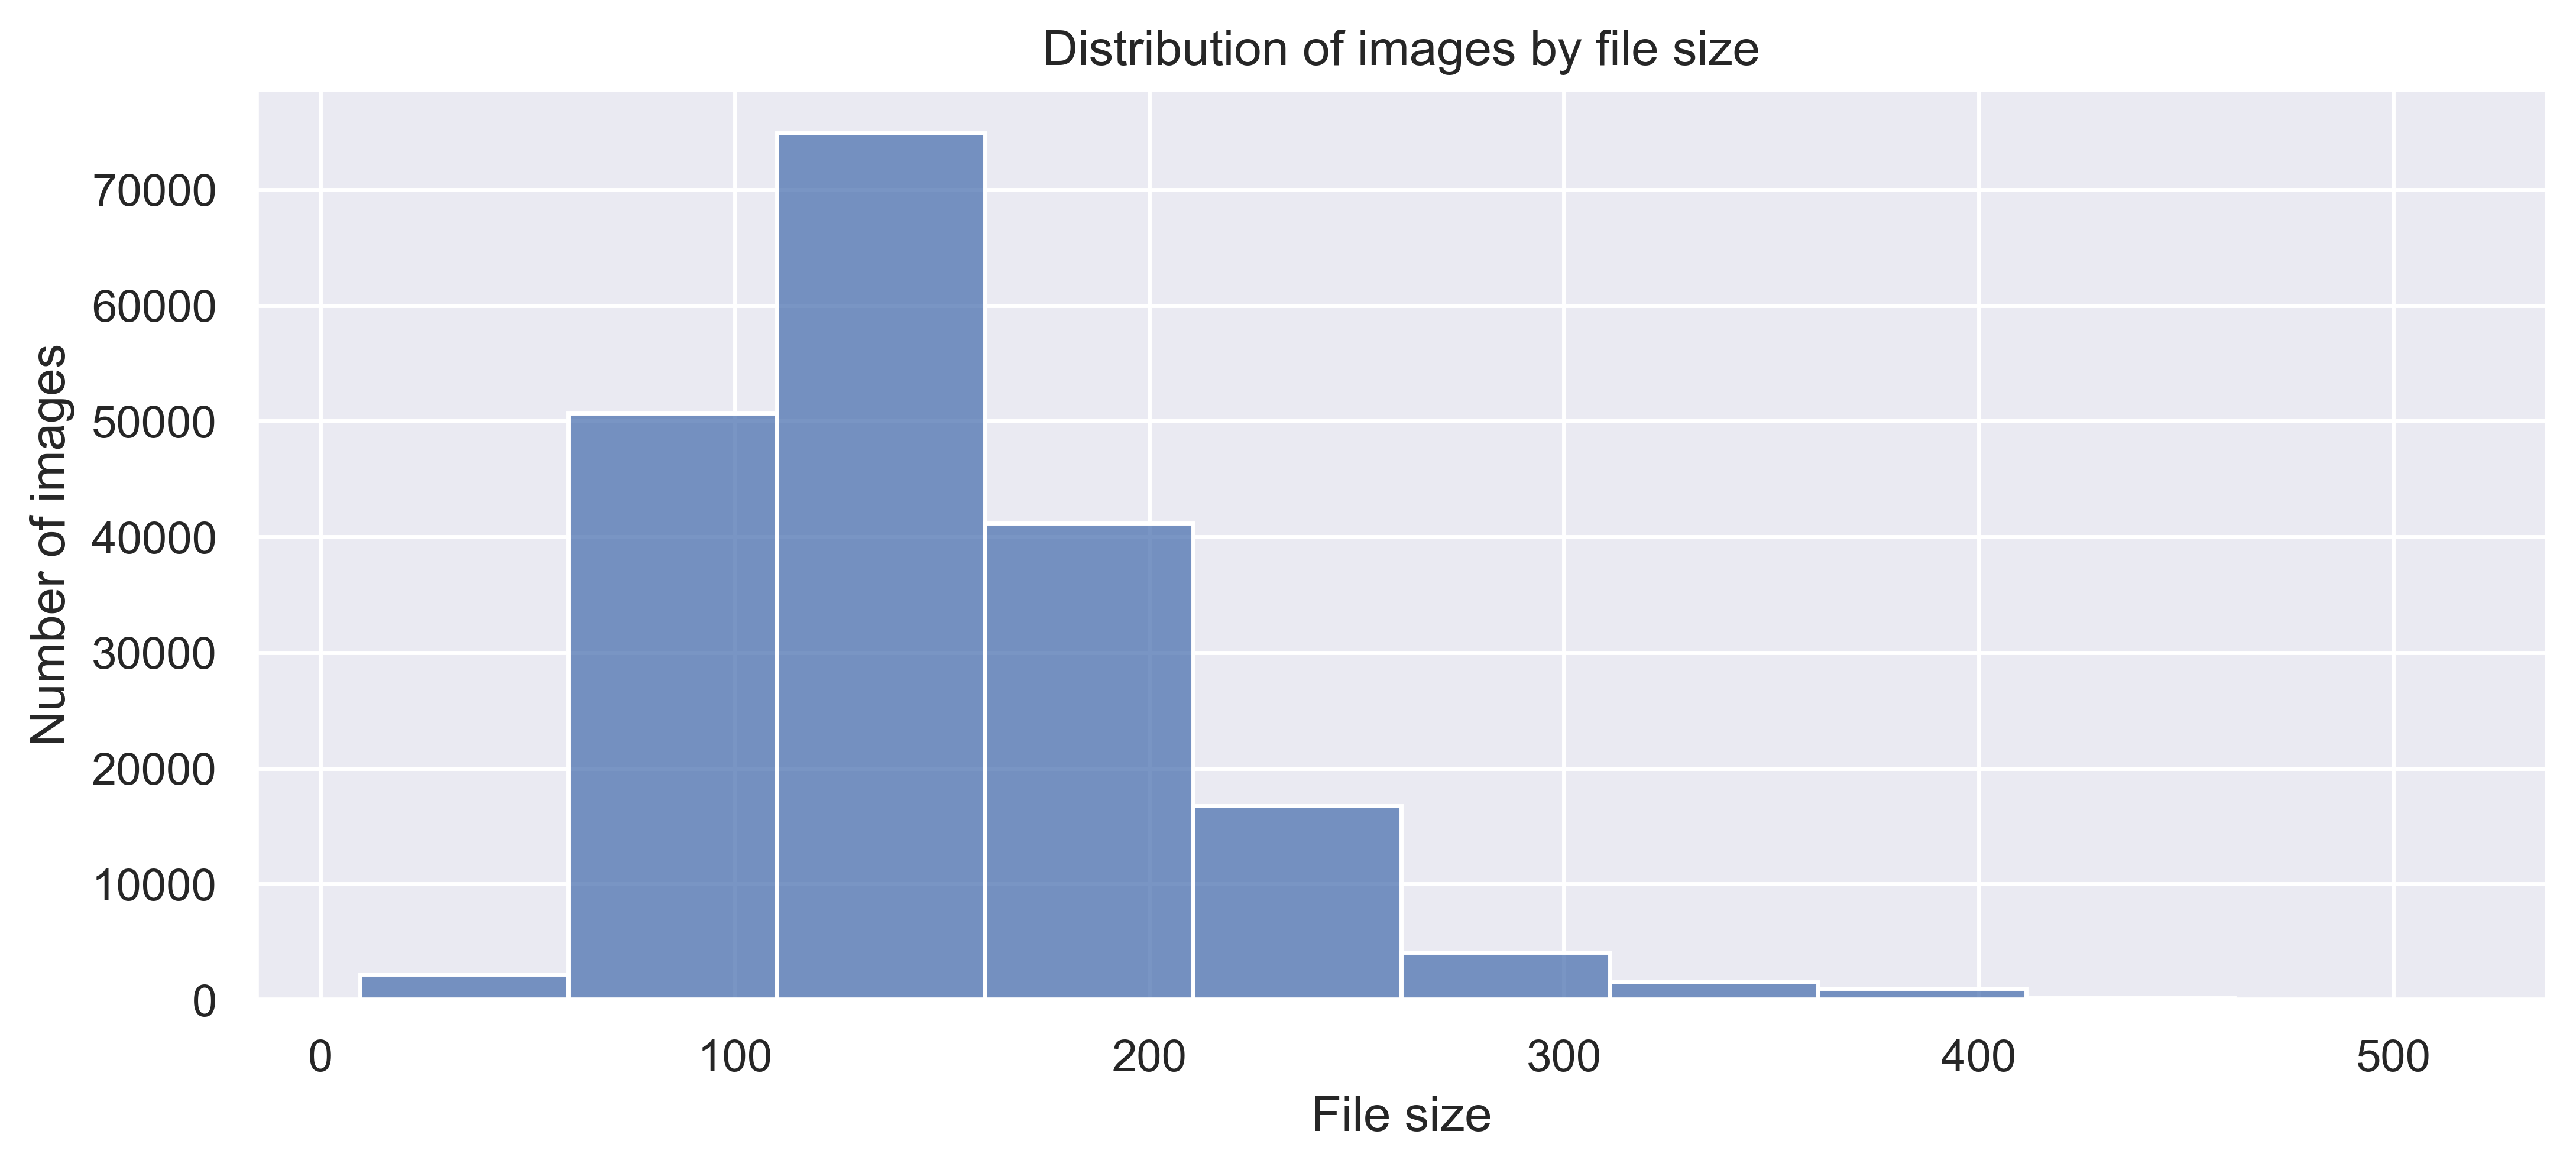

In [15]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=500)
ships_dist_count = sns.histplot(ax=ax, data=train_df_grouped, x='FileSizeKb', bins=20, binwidth=50)

ax.set_title("Distribution of images by file size")
ax.set_ylabel("Number of images")
ax.set_xlabel("File size")
plt.show()

In [18]:
# Filter files smaller than 50kb
small_images = train_df_grouped[train_df_grouped['FileSizeKb'] < 50]
print(f"Number of images smaller than 50 kb: {small_images.shape[0]} | {round(small_images.shape[0]/train_df_grouped.shape[0], 2) * 100}%")

Number of images smaller than 50 kb: 1266 | 1.0%


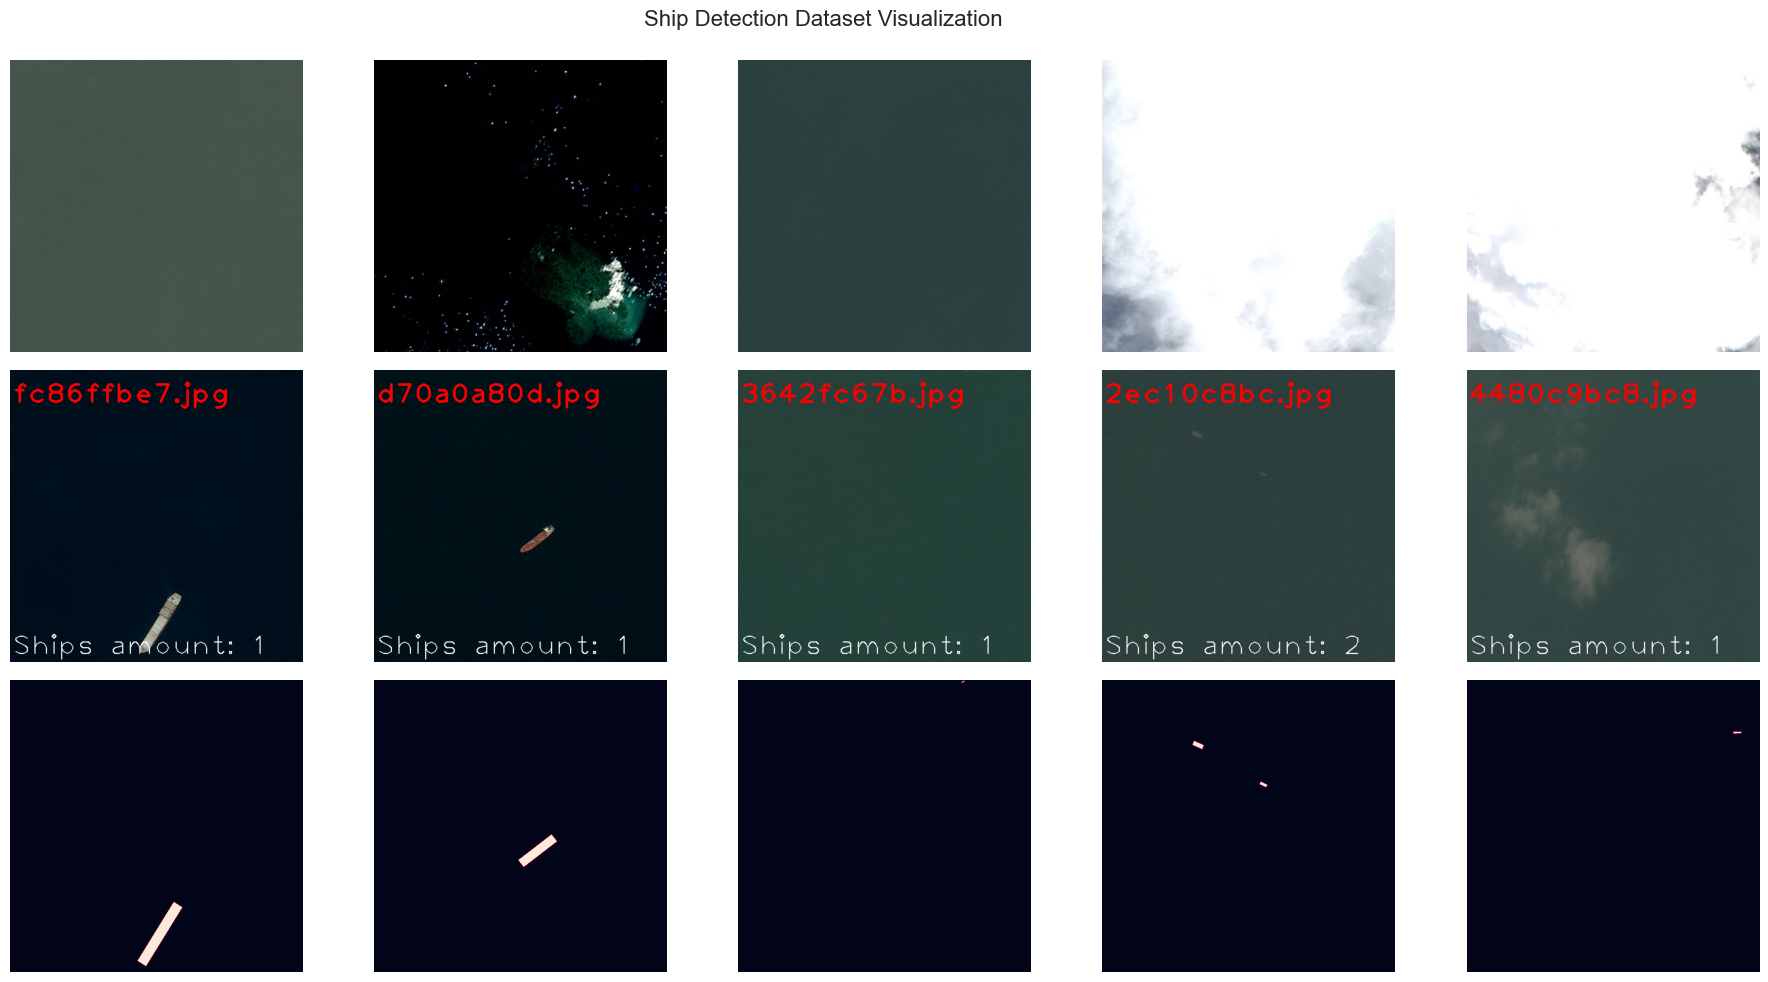

In [21]:
# Feel fry to change the "seed" to see different images
seed = 2
display_images(small_images, train_images_folder, seed)

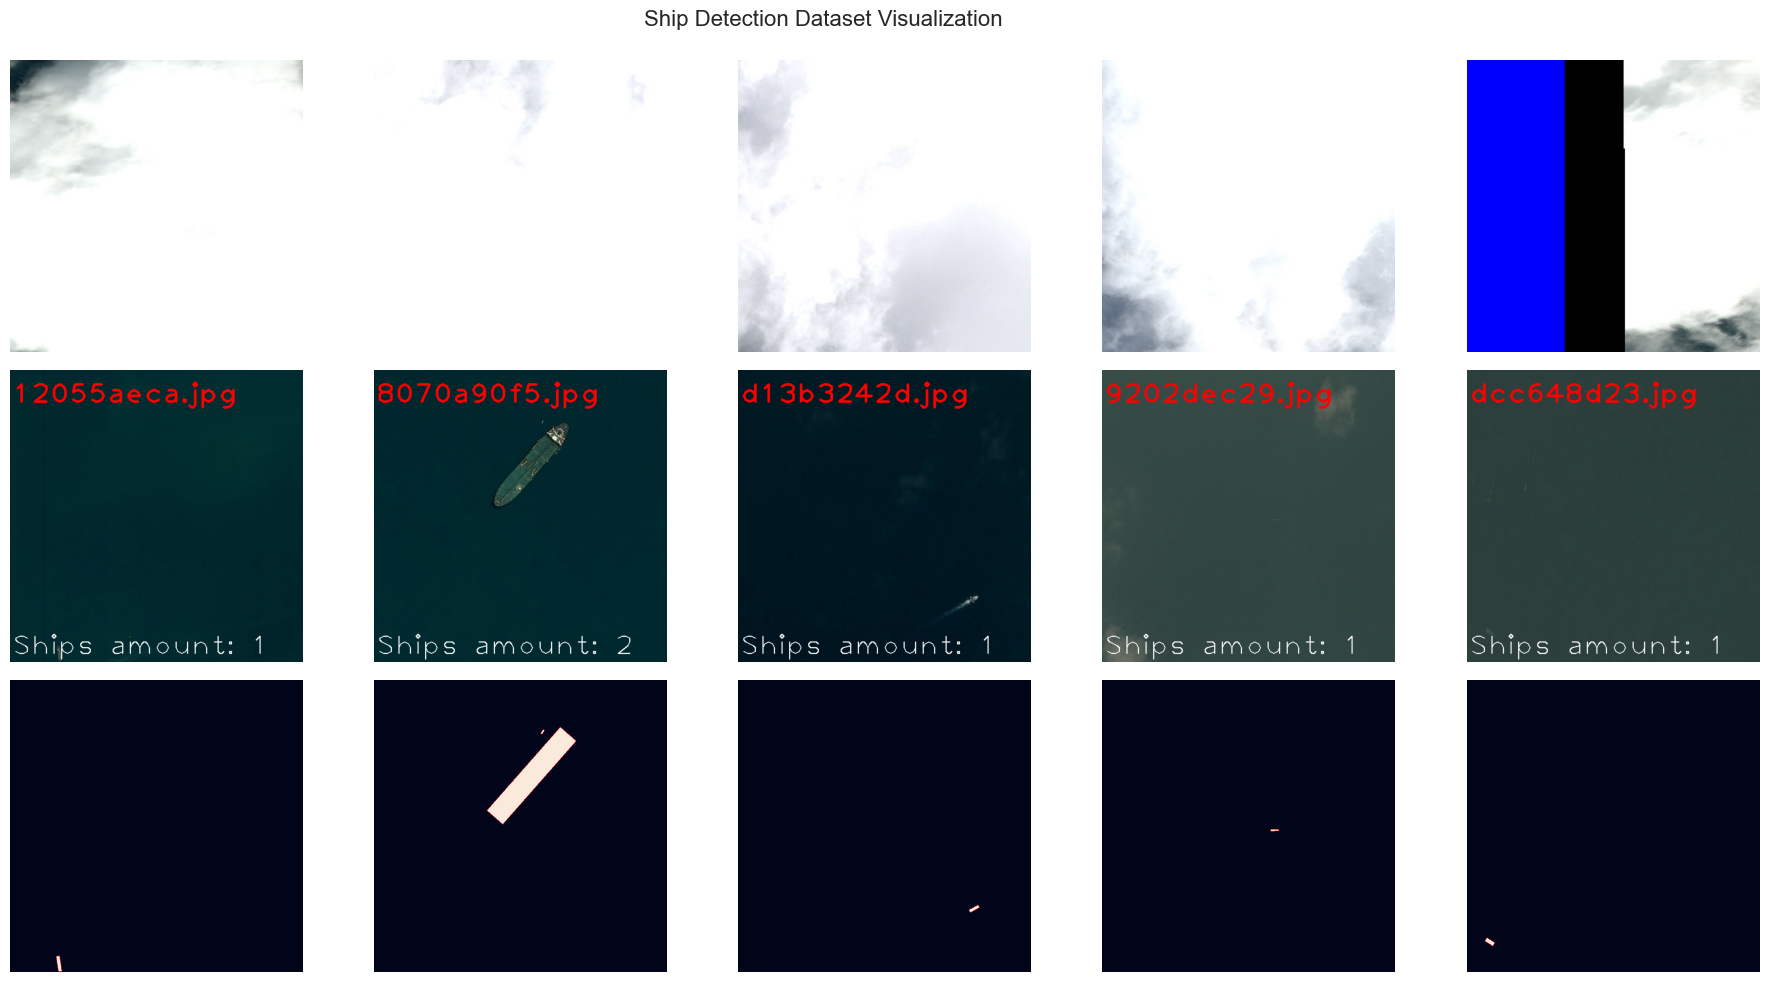

In [24]:
seed = 5
display_images(small_images, train_images_folder, seed)

It's evident that some images are damaged. Checking all images for damage is inefficient given the dataset size. 

A more practical solution would be to exclude all images smaller than 50kb, which accounts for only 1% of all images in the dataset.


## Conclusions

1. One mask corresponds to one ship, and each mask is a unique record in the dataset.
2. There is a significant class imbalance (1 to 5) between images with ships and images without ships.
3. The distribution of ship counts in images where they are present is heavily skewed to the right, with more than half of the cases containing only one ship.
4. Some images have labeling errors, which may affect model evaluation.
5. Within the images themselves, there is a significant class imbalance, with more than 99% of pixels being background.
6. Images of 50kb or less make up 1% of the entire dataset, and some of these are damaged.